In [8]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
%matplotlib inline

In [5]:
data = np.load("data/DK_time_series_3000000.npy")

train = data[:-500000]
test =  data[-500000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [ ]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+1:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [ ]:
train_dataloader = DataLoader(train_inout_seq, batch_size=10, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=10, shuffle=True, drop_last=True)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
    
        return x + self.pe[:x.size(0), :]
          

class TransAm(nn.Module):
    def __init__(self,feature_size=250, nhead=10, num_layers=2,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        #print(src.size())
        src = self.pos_encoder(src)
        #print(src.size())

        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        #print(output.size())
        
        output = self.decoder(output)
        #print(output.size())
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [ ]:
model_trans = TransAm().to('cuda')

In [ ]:
input_window = 20

In [ ]:
def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

In [ ]:
batch_size = 64

In [ ]:
def run_epoch(train_data, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        if is_training:
            optimizer.zero_grad()
            
        #print(x.size())
        #print(y.size())
        #x = torch.transpose(x, 0, 1).reshape((20, 10, 1)).float().to('cuda')
        #y = y.view(-1).float().to('cuda')

        out = model(data.to('cuda'))
        loss = criterion(out, targets.to('cuda'))

        if is_training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

        epoch_loss += (loss.detach().item() / batch_size)

    #lr = scheduler.get_last_lr()[0]

    return epoch_loss

In [ ]:
criterion = nn.MSELoss()
lr = 0.005 
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer,  1.0, gamma=0.95)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train = run_epoch(train_inout_seq, is_training=True)
    loss_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val))

In [ ]:
#torch.save(model.state_dict(), "./TransformerChaosLarge")

In [ ]:
def GetRmseTransformer(model, train_dataloader, val_dataloader, test, std, mean):
    model.eval()

    rmse = []
    transformer_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(test)- 20)%64
        predicted_val = np.array([])
        for batch, i in enumerate(range(0, len(test_inout_seq) - 1, batch_size)):
            data, targets = get_batch(test_inout_seq, i,batch_size)
            if data.size()[1] < 64:
                break
            cur_x = data
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                #cur_x = torch.hstack((cur_x[:, 1:], out.cpu()))
                cur_x = torch.vstack((cur_x[1:, :], out[-1].cpu().reshape((1, 64, 1))))
            #out = model1(cur_x.to('cuda'))
            #predicted_val = np.concatenate((predicted_val, out[-1, :, 0].cpu().detach().numpy()))
            predicted_val = np.concatenate((predicted_val, cur_x[-1, :, 0].cpu().detach().numpy()))
            
        transformer_predicts.append(np.array(predicted_val)*std+mean)
        
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, transformer_predicts

In [ ]:
rmse_transformer, transformer_predicts = GetRmseTransformer(model_trans, train_dataloader, test_dataloader, test, std, mean)

# LSTM

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Floating
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [9]:
lstm_train = data[:-500000]
lstm_test =  data[-500000:]

mean = lstm_train.mean()
std = lstm_train.std()
#sigmastest = np.abs(test - mean)
train_norm = (lstm_train - mean)/std
test_norm = (lstm_test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [10]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [11]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

In [14]:
model_lstm = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model_lstm = model_lstm.to('cuda')

In [16]:
def run_epoch(model, dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)


    return epoch_loss

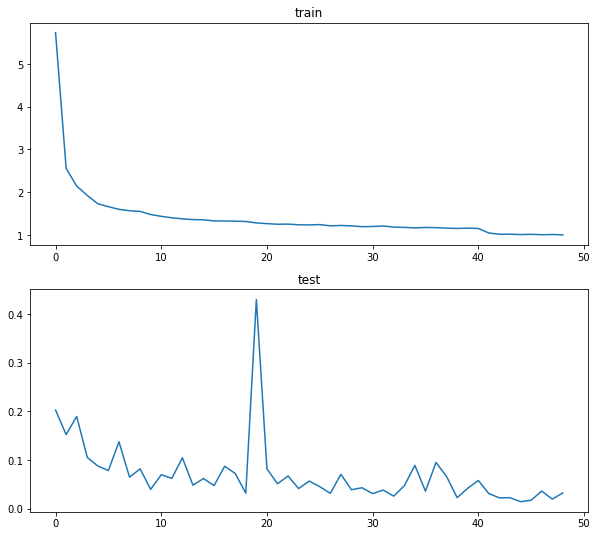

Epoch[49/175] | loss train:1.003810, test:0.032598


In [ ]:
# define optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-9)
lr = 0.001
epochs = 175

losses_train = []
losses_test = []
# begin training
for epoch in range(epochs): 
    if epoch > 40:
        lr = 0.0005
    if epoch > 100:
        lr = 0.0001
    optimizer = optim.Adam(model_lstm.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9)    
    loss_train = run_epoch(model_lstm, train_dataloader, is_training=True)
    loss_val = run_epoch(model_lstm, test_dataloader)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))

In [ ]:
def GetRmse(model, train_dataloader, val_dataloader, test, std, mean):
    model.eval()

    rmse = []
    
    lstm_predicts = []
    for k in tqdm(range(1, 20)):
        test_right_part = (len(lstm_test)- 20)%64
        predicted_val = np.array([])
        for idx, (x, y) in enumerate(val_dataloader):
            x = torch.reshape(x, (64, 20, 1)).to('cuda')
            cur_x = x
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                cur_x = torch.hstack((cur_x[:, 1:], torch.reshape(out, (64, 1, 1))))
            predicted_val = np.concatenate((predicted_val, cur_x[:, -1, 0].cpu().detach().numpy()))
            
        lstm_predicts.append(np.array(predicted_val)*std+mean)
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(lstm_test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(lstm_test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse, lstm_predicts

In [ ]:
rmse_chaos, lstm_predicts = GetRmse(model_lstm, train_dataloader, test_dataloader, test, std, mean)